<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/neo4j/Neo4J_Machine_Learning_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

https://neo4j.com/docs/graph-data-science/current/machine-learning/machine-learning/


In GDS, our pipelines offer an end-to-end workflow, from feature extraction to training and applying machine learning models. Pipelines can be inspected through the Pipeline catalog. The trained models can then be accessed via the Model catalog and used to make predictions about your graph.



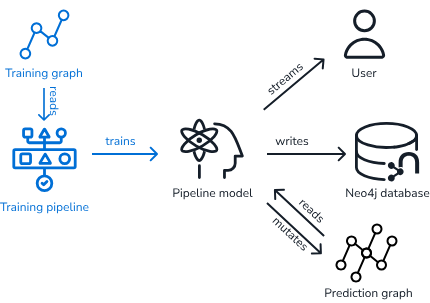


The notebook exemplifies how to use the `graphdatascience` Python library to operate Neo4j GDS.



# Machine learning

To help with building the ML models, there are additional guides for pre-processing and hyperparameter tuning available in:

- Pre-processing

- Training methods



The Neo4j GDS library includes the following pipelines to train and apply machine learning models, grouped by quality tier:

Beta

- Node Classification Pipelines

- Link Prediction Pipelines

Alpha

- Node Regression Pipelines

#  Pre-processing

In most machine learning scenarios, several pre-processing steps are applied to produce data that is amenable to machine learning algorithms. This is also true for graph data. The goal of pre-processing is to provide good features for the learning algorithm. As part of our pipelines we offer adding such pre-procesing steps as node property steps (see Node Classification or Link Prediction).

Some options include:

- Node embeddings

- Centrality algorithms

- Scale Properties to normalize node features

- One Hot Encoding to encode string properties as numeric arrays

## Prerequisites

Running this notebook requires a Neo4j server with a recent version (2.0+) of GDS installed.
We recommend using Neo4j Desktop with GDS, or AuraDS.

The `graphdatascience` Python library needs to be installed as well. See the examples in the Setup section below and in the [client installation instructions](https://neo4j.com/docs/graph-data-science-client/current/installation/).

## Setup

We start by installing and importing our dependencies, and setting up our GDS client connection to the database.

In [16]:
# Install necessary dependencies
%pip install graphdatascience

In [2]:
import os
from graphdatascience import GraphDataScience

# Get Neo4j DB URI and credentials from environment if applicable
NEO4J_URI = "bolt://44.204.192.158:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "kills-man-labels"
NEO4J_AUTH = (
       NEO4J_USER,
       NEO4J_PASSWORD,
    )


gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH)

In [43]:
from graphdatascience.server_version.server_version import ServerVersion

assert gds.server_version() >= ServerVersion(1, 8, 0)

In [64]:
gds.version()

'2.6.5'

#  Scale Properties

The Scale Properties algorithm is a utility algorithm that is used to pre-process node properties for model training or post-process algorithm results such as PageRank scores. It scales the node properties based on the specified scaler. Multiple properties can be scaled at once and are returned in a list property.

The input properties must be numbers or lists of numbers. The lists must all have the same size. The output property will always be a list. The size of the output list is equal to the sum of length of the input properties. That is, if the input properties are two scalar numeric properties and one list property of length three, the output list will have a total length of five.

If a node is missing a value for a property, the node will be omitted from scaling of that property. It will receive an output value of NaN. This includes list properties.

There are a number of supported scalers for the Scale Properties algorithm. These can be configured using the scaler configuration parameter.

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/scale-properties/#algorithms-scale-properties-minmax

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/scale-properties/#algorithms-scale-properties-max

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/scale-properties/#algorithms-scale-properties-mean

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/scale-properties/#algorithms-scale-properties-log

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/scale-properties/#algorithms-scale-properties-standard

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/scale-properties/#algorithms--scale-properties-center


## Example graph creation

We now create a graph of products and customers in the database. The `amount` relationship property represents the average weekly amount of money spent by a customer on a given product.

In [65]:
# The `run_cypher` method can be used to run arbitrary Cypher queries on the database.
_ = gds.run_cypher(
    """
        CREATE
  (:Hotel {avgReview: 4.2, buildYear: 1978, storyCapacity: [32, 32, 0], name: 'East'}),
  (:Hotel {avgReview: 8.1, buildYear: 1958, storyCapacity: [18, 20, 0], name: 'Plaza'}),
  (:Hotel {avgReview: 19.0, buildYear: 1999, storyCapacity: [100, 100, 70], name: 'Central'}),
  (:Hotel {avgReview: -4.12, buildYear: 2005, storyCapacity: [250, 250, 250], name: 'West'}),
  (:Hotel {avgReview: 0.01, buildYear: 2020, storyCapacity: [1250, 1250, 900], name: 'Polar'}),
  (:Hotel {avgReview: 3.3, buildYear: 1981, storyCapacity: [240, 240, 0], name: 'Beach'}),
  (:Hotel {avgReview: 6.7, buildYear: 1984, storyCapacity: [80, 0, 0], name: 'Mountain'}),
  (:Hotel {avgReview: -1.2, buildYear: 2010, storyCapacity: [55, 20, 0], name: 'Forest'})
    """
)

## Projecting into GDS

In order to be able to analyze the data in our database, we proceed to projecting it into memory where GDS can operate on it.

In [66]:
# We define how we want to project our database into GDS

gds.run_cypher(
    """
       CALL gds.graph.project(
  'myGraph',
  'Hotel',
  '*',
  { nodeProperties: ['avgReview', 'buildYear', 'storyCapacity'] }
)
    """
)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Hotel': {'label': 'Hotel', 'properties': {'s...","{'__ALL__': {'aggregation': 'DEFAULT', 'orient...",myGraph,8,0,5


In [67]:
gds.run_cypher(
    """
       CALL gds.scaleProperties.stream.estimate('myGraph', {
  nodeProperties: ['buildYear', 'storyCapacity'],
  scaler: 'MinMax'
})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
    """
)

,nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
0,8,0,600,600,600 Bytes


In [68]:
gds.run_cypher(
    """
      CALL gds.scaleProperties.stream('myGraph', {
  nodeProperties: ['buildYear', 'avgReview'],
  scaler: 'MinMax'
}) YIELD nodeId, scaledProperty
RETURN gds.util.asNode(nodeId).name AS name, scaledProperty
  ORDER BY name ASC
    """
)

,name,scaledProperty
0,Beach,"[0.3709677419354839, 0.3209342560553633]"
1,Central,"[0.6612903225806451, 1.0]"
2,East,"[0.3225806451612903, 0.35986159169550175]"
3,Forest,"[0.8387096774193549, 0.12629757785467127]"
4,Mountain,"[0.41935483870967744, 0.4679930795847751]"
5,Plaza,"[0.0, 0.5285467128027681]"
6,Polar,"[1.0, 0.17863321799307957]"
7,West,"[0.7580645161290323, 0.0]"


In [69]:
gds.run_cypher(
    """
     CALL gds.scaleProperties.mutate('myGraph', {
  nodeProperties: ['buildYear', 'avgReview'],
  scaler: 'Mean',
  mutateProperty: 'hotelFeatures'
}) YIELD nodePropertiesWritten, scalerStatistics
    """
)

,nodePropertiesWritten,scalerStatistics
0,8,"{'avgReview': {'min': [-4.12], 'max': [19.0], ..."


In [70]:
gds.run_cypher(
    """
     CALL gds.scaleProperties.stats('myGraph', {
  nodeProperties: ['buildYear', 'avgReview'],
  scaler: 'center'
}) YIELD scalerStatistics
    """
)

,scalerStatistics
0,"{'avgReview': {'avg': [4.49875]}, 'buildYear':..."


In [72]:
gds.run_cypher(
    """
    CALL gds.scaleProperties.write('myGraph', {
  nodeProperties: ['buildYear', 'avgReview'],
  scaler: 'stdscore',
  writeProperty: 'hotelStdScore'
}) YIELD nodePropertiesWritten, scalerStatistics
    """
)

,nodePropertiesWritten,scalerStatistics
0,8,"{'avgReview': {'std': [6.6758378453569405], 'a..."


Indeed, "Kale" is the one product that the Person named "Annie" buys that is also not purchased by the Person named "Matt".

In [73]:
gds.run_cypher(
    """
    CALL gds.scaleProperties.stream('myGraph', {
  nodeProperties: ['avgReview', 'storyCapacity'],
  scaler: 'StdScore'
}) YIELD nodeId, scaledProperty
RETURN gds.util.asNode(nodeId).name AS name, scaledProperty AS features
  ORDER BY name ASC
    """
)

,name,features
0,Beach,"[-0.17956547594003255, -0.03401933556831381, 0..."
1,Central,"[2.172199255871029, -0.3968922482969945, -0.35..."
2,East,"[-0.0447509371737933, -0.5731448059080679, -0...."
3,Forest,"[-0.8536381697712285, -0.513529970245499, -0.5..."
4,Mountain,"[0.3297338927324267, -0.4487312358296632, -0.6..."
5,Plaza,"[0.5394453974799098, -0.609432097180936, -0.55..."
6,Polar,"[-0.6723875120966181, 2.583849534831454, 2.570..."
7,West,"[-1.2910364511016934, -0.00809984180197948, 0...."


## Cleaning up

Before finishing we can clean up the example data from both the GDS in-memory state and the database.

In [74]:
# Remove our projection from the GDS graph catalog


# Remove all the example data from the database
_ = gds.run_cypher("MATCH (n) DETACH DELETE n")

# One Hot Encoding

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/one-hot-encoding/

The One Hot Encoding function is used to convert categorical data into a numerical format that can be used by Machine Learning libraries.

In [75]:
_ = gds.run_cypher(
    """
       CREATE (french:Cuisine {name:'French'}),
       (italian:Cuisine {name:'Italian'}),
       (indian:Cuisine {name:'Indian'}),

       (zhen:Person {name: "Zhen"}),
       (praveena:Person {name: "Praveena"}),
       (michael:Person {name: "Michael"}),
       (arya:Person {name: "Arya"}),

       (praveena)-[:LIKES]->(indian),
       (zhen)-[:LIKES]->(french),
       (michael)-[:LIKES]->(french),
       (michael)-[:LIKES]->(italian)
    """
)

In [76]:
gds.run_cypher(
    """
       MATCH (cuisine:Cuisine)
WITH cuisine
  ORDER BY cuisine.name
WITH collect(cuisine) AS cuisines
MATCH (p:Person)
RETURN p.name AS name, gds.alpha.ml.oneHotEncoding(cuisines, [(p)-[:LIKES]->(cuisine) | cuisine]) AS value
  ORDER BY name
    """
)

,name,value
0,Arya,"[0, 0, 0]"
1,Michael,"[1, 0, 1]"
2,Praveena,"[0, 1, 0]"
3,Zhen,"[1, 0, 0]"


In [77]:

# Remove all the example data from the database
_ = gds.run_cypher("MATCH (n) DETACH DELETE n")

# Split Relationships

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/split-relationships/


The Split relationships algorithm is a utility algorithm that is used to pre-process a graph for model training. It splits the relationships into a holdout set and a remaining set. The holdout set is divided into two classes: positive, i.e., existing relationships, and negative, i.e., non-existing relationships. The class is indicated by a label property on the relationships. This enables the holdout set to be used for training or testing a machine learning model. Both, the holdout and the remaining relationships are added to the projected graph.

If the configuration option relationshipWeightProperty is specified, then the corresponding relationship property is preserved on the remaining set of relationships. Note however that the holdout set only has the label property; it is not possible to induce relationship weights on the holdout set as it also contains negative samples.

In [93]:
gds.run_cypher(
    """
       CREATE
    (n0:Label),
    (n1:Label),
    (n2:Label),
    (n3:Label),
    (n4:Label),
    (n5:Label),

    (n0)-[:TYPE { prop: 0} ]->(n1),
    (n1)-[:TYPE { prop: 1} ]->(n2),
    (n2)-[:TYPE { prop: 4} ]->(n3),
    (n3)-[:TYPE { prop: 9} ]->(n4),
    (n4)-[:TYPE { prop: 16} ]->(n5)
    """
)

""


In [94]:
# We define how we want to project our database into GDS
node_projection = ["Label"]
relationship_projection = {"TYPE": {"orientation": "UNDIRECTED", "properties": "prop"}}

# Before actually going through with the projection, let's check how much memory is required
result = gds.graph.project.estimate(node_projection, relationship_projection)

print(f"Required memory for native loading: {result['requiredMemory']}")

Required memory for native loading: 544 KiB


In [95]:
# For this small graph memory requirement is low. Let us go through with the projection
G, result = gds.graph.project("graph2", node_projection, relationship_projection)

print(f"The projection took {result['projectMillis']} ms")

# We can use convenience methods on `G` to check if the projection looks correct
print(f"Graph '{G.name()}' node count: {G.node_count()}")
print(f"Graph '{G.name()}' node labels: {G.node_labels()}")

The projection took 5 ms
Graph 'graph2' node count: 6
Graph 'graph2' node labels: ['Label']


In [96]:
G

Graph({'graphName': 'graph2', 'nodeCount': 6, 'relationshipCount': 10, 'database': 'neo4j', 'configuration': {'relationshipProjection': {'TYPE': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'prop': {'aggregation': 'DEFAULT', 'property': 'prop', 'defaultValue': None}}, 'type': 'TYPE'}}, 'readConcurrency': 4, 'relationshipProperties': {}, 'nodeProperties': {}, 'jobId': 'ffad4aa4-efdb-4871-ae25-e81b5901e8e9', 'nodeProjection': {'Label': {'label': 'Label', 'properties': {}}}, 'logProgress': True, 'creationTime': neo4j.time.DateTime(2024, 4, 18, 17, 19, 24, 438146884, tzinfo=<UTC>), 'validateRelationships': False, 'sudo': False}, 'schema': {'graphProperties': {}, 'nodes': {'Label': {}}, 'relationships': {'TYPE': {'prop': 'Float (DefaultValue(NaN), PERSISTENT, Aggregation.NONE)'}}}, 'memoryUsage': '2339 KiB'})

In [97]:
result =  gds.alpha.ml.splitRelationships.mutate(G,
                                                 holdoutRelationshipType= 'TYPE_HOLDOUT',
                                                remainingRelationshipType= 'TYPE_REMAINING',
                                                 holdoutFraction= 0.2,
                                                 negativeSamplingRatio = 1.0,
                                                 randomSeed = 1337)


In [98]:
result

preProcessingMillis                                                     0
computeMillis                                                           0
mutateMillis                                                            1
relationshipsWritten                                                   10
configuration           {'randomSeed': 1337, 'jobId': '0ce9a5b5-9db9-4...
Name: 0, dtype: object

In [99]:
gds.run_cypher(
    """
      call gds.graph.relationships.stream('graph2')
    """
)

,sourceNodeId,targetNodeId,relationshipType
0,2,3,TYPE_REMAINING
1,2,3,TYPE
2,3,2,TYPE_REMAINING
3,3,4,TYPE_REMAINING
4,3,2,TYPE
5,3,4,TYPE
6,4,3,TYPE_REMAINING
7,4,5,TYPE_REMAINING
8,4,2,TYPE_HOLDOUT
9,4,3,TYPE


In [100]:

# Remove all the example data from the database
_ = gds.run_cypher("MATCH (n) DETACH DELETE n")